# Sales Of Summer Clothes on E-Commerce Platform - Wish

Background:

This dataset on Kaggle was originally scraped from Wish E-Commerce Platform. It contains product listings, products ratings, sales performance, and merchant/supplier information if you type "Summer" in the search field of the platform. 

Key Business Objectives:

1. What are the top selling categories, product size and colors for Summer?
2. Which key variables/factors successfully predict the number of units sold?
3. Can you build a machine learning model to predict the number of units sold?

Source Data:
The data was sourced from kaggle.Here's a link:

https://www.kaggle.com/jmmvutu/summer-products-and-sales-in-ecommerce-wish

### Step 1 : Import All Relevant Libraries 

In [1]:

import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn import linear_model
from sklearn.linear_model import LassoCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_selection import SelectKBest, chi2, f_classif, SelectFromModel, RFECV, VarianceThreshold
from fuzzywuzzy import fuzz,process

import matplotlib.pyplot as plt

C:\ProgramData\Anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


### Step 2 : Import the Dataset and Create 'ID' column as index 

In [2]:
df=pd.read_csv(r"C:\Users\aksha\Desktop\Akshay\training\summer-products-with-rating-and-performance_2020-08.csv")
df['product_color'] = df['product_color'].astype('str')
df['product_variation_size_id'] = df['product_variation_size_id'].astype('str')
df = df.reset_index(drop=True)
#df.columns[0] = 'New_ID'
df['id'] = df.index + 1
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1573 entries, 0 to 1572
Data columns (total 44 columns):
title                           1573 non-null object
title_orig                      1573 non-null object
price                           1573 non-null float64
retail_price                    1573 non-null int64
currency_buyer                  1573 non-null object
units_sold                      1573 non-null int64
uses_ad_boosts                  1573 non-null int64
rating                          1573 non-null float64
rating_count                    1573 non-null int64
rating_five_count               1528 non-null float64
rating_four_count               1528 non-null float64
rating_three_count              1528 non-null float64
rating_two_count                1528 non-null float64
rating_one_count                1528 non-null float64
badges_count                    1573 non-null int64
badge_local_product             1573 non-null int64
badge_product_quality           1573 non-nul

### Step 3: Data Pre-Processing 
   
It's a key step in Machine Learning project to ensure that data is clean and error-free.

Below are some important/key steps:

a. Drop irrelevant/unnecessary variables.
b. Check and impute missing values wherever appropriate
c. Create new variables from existing features
d. Clean categorical variables
e. Transform categorical variables to numeric variables

#### Step 3a : Drop Irrelevant Features

The variables below were rendered to be irrelevant for use. These don't contain any vital information that could help predict number of units sold.

In [3]:
df=df.drop(['tags','currency_buyer','shipping_option_name','merchant_profile_picture','urgency_text','title','crawl_month','theme','product_url','product_picture','merchant_title','merchant_name','merchant_info_subtitle','merchant_id'],axis=1)

#### Step 3b : Check and Impute Missing Values

In [4]:
def missing_values_table(df):
    '''
    Input - Dataframe that has all relevant variables for consideration.
    
    Output - Displays the total number of variables/columns in the dataset. In addition, it also 
    generates count of missing values for each column.
    
    '''    
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[
    mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
    "There are " + str(mis_val_table_ren_columns.shape[0]) +
    " columns that have missing values.")
    return mis_val_table_ren_columns
    
df_qa=missing_values_table(df)
df_qa

Your selected dataframe has 30 columns.
There are 7 columns that have missing values.


,Missing Values,% of Total Values
has_urgency_banner,1100,69.9
rating_five_count,45,2.9
rating_four_count,45,2.9
rating_three_count,45,2.9
rating_two_count,45,2.9
rating_one_count,45,2.9
origin_country,17,1.1


#### Step 3b : 

Impute Missing Values.

Numeric:
The missing values will be imputed with zero for rating/urgency banner numeric variables. It's safe to assume that no one rated those products. 

Character:
The number of missing values for country of origin is neglibile so it will be dealt with it later.

#### Step 3c: 
Create new/derived variables from existing variables.

a. Discount rate which is % change in price vs retail price
b. Distribution of user ratings for each product
c. Distribution of badges (local product, product quality and fast shipping etc.) awarded to each product

In [5]:
df=df.fillna(0)

df['diff_price'] =df['retail_price'] - df['price']
df['discount_flag'] = np.where(df['diff_price'] > 1,1,0)
df['pct_discount_off'] = (df['retail_price'] - df['price'])/df['retail_price']
df['pct_discount_off'] = np.round(np.where(df['pct_discount_off']>0,df['pct_discount_off'],0),2)

df['pct_rating_one']=df['rating_one_count']/df['rating_count']
df['pct_rating_two']=df['rating_two_count']/df['rating_count']
df['pct_rating_three']=df['rating_three_count']/df['rating_count']
df['pct_rating_four']=df['rating_four_count']/df['rating_count']
df['pct_rating_five']=df['rating_five_count']/df['rating_count']


df['pct_badge_local_product'] = np.round(np.where(df['badges_count'] > 0, df['badge_local_product']/df['badges_count'], 0), 2)
df['pct_badge_product_quality'] = np.round(np.where(df['badges_count'] > 0, df['badge_product_quality']/df['badges_count'], 0), 2)
df['pct_badge_fast_shipping'] = np.round(np.where(df['badges_count'] > 0, df['badge_fast_shipping']/df['badges_count'], 0), 2)

df.head()

,title_orig,price,retail_price,units_sold,uses_ad_boosts,rating,rating_count,rating_five_count,rating_four_count,rating_three_count,...,discount_flag,pct_discount_off,pct_rating_one,pct_rating_two,pct_rating_three,pct_rating_four,pct_rating_five,pct_badge_local_product,pct_badge_product_quality,pct_badge_fast_shipping
0,2020 Summer Vintage Flamingo Print Pajamas Se...,16.00,14,100,0,3.76,54,26.0,8.0,10.0,...,0,0.00,0.166667,0.018519,0.185185,0.148148,0.481481,0.0,0.0,0.0
1,Women's Casual Summer Sleeveless Sexy Mini Dress,8.00,22,20000,1,3.45,6135,2269.0,1027.0,1118.0,...,1,0.64,0.175550,0.104971,0.182233,0.167400,0.369845,0.0,0.0,0.0
2,2020 New Arrival Women Spring and Summer Beach...,8.00,43,100,0,3.57,14,5.0,4.0,2.0,...,1,0.81,0.214286,0.000000,0.142857,0.285714,0.357143,0.0,0.0,0.0
3,Hot Summer Cool T Shirt for Women Fashion Tops...,8.00,8,5000,1,4.03,579,295.0,119.0,87.0,...,0,0.00,0.062176,0.072539,0.150259,0.205527,0.509499,0.0,0.0,0.0
4,Women Summer Shorts Lace Up Elastic Waistband ...,2.72,3,100,1,3.10,20,6.0,4.0,2.0,...,0,0.09,0.300000,0.100000,0.100000,0.200000,0.300000,0.0,0.0,0.0


#### Step 3d : Clean Categorical Variables
    
A quick frequency distribution on some categorical variables such as  'Product Color', 'Product Variation Size Id' and'Origin_Country' indicates that data is not clean.

It's a must to clean and transform the categorical variables to use these are predictors in building a good model.

In [6]:
def color(col):
    if '&' in col:
        return 'dual'
    else:
        return col
    return col

df['product_color'] = df['product_color'].apply(color)

df['product_color'].value_counts()

black                 302
white                 254
yellow                105
pink                   99
blue                   99
red                    93
green                  90
grey                   71
purple                 53
nan                    41
dual                   40
armygreen              31
navyblue               28
winered                28
orange                 27
multicolor             20
beige                  14
khaki                  12
lightblue              12
gray                   11
rosered                 8
skyblue                 8
coffee                  7
brown                   7
darkblue                6
rose                    5
floral                  5
lightpink               4
navy                    4
fluorescentgreen        4
                     ... 
ivory                   1
blackwhite              1
greysnakeskinprint      1
nude                    1
lightgray               1
wine red                1
darkgreen               1
RED         

#### Step 3d : Clean Categorical Variables - Product Color

As one can see, there is a lot of distinct values for 'Product Color'. Most of these values are either redundant or irrelevant due to low frequency count. It's best to group like colors together or to run a string-to-string fuzzy match algorithm to avoid redundancy. In addition, I prefer to create a category called 'other' which contains colors that are insignificant or it contains low frequency distribution.

The goal/objective is to identify top 10-15 distinct values and create dummy variables to offer them as predictors in model building process.
    
One simple approach I took was the following:
    
1. Create a list of colors (unique in nature) that have highest frequency distribution based on the raw/untransformed values in the original column. This is our "Reference list"

2. Create a list of all possible unique values (colors) in the original column. This is our "Input List".

3. Run a fuzzy string-to-string matching algorithm between the "Reference List" and "Input List" using fuzz module of fuzzywuzzy package. More details can be found here:
    
4. Basically, this algorithm will match an element from "Input List" with each and every element in "Reference List" to generate a similarity score for each and every pair/combination.

5. Finally, I chose to preserve only those combinations that have a very high similarity score  (>90). This indicates a strong match to the values (colors) in "Reference List".

Note: It's possible to have duplicates especially when a value 'blackwhite' was assigned to both 'black' and 'white' categories. It's best to remove these duplicate values. 



In [7]:
ref_list = ['black', 'brown', 'green','white','orange','brown','beige','grey','blue','yellow','red','dual','pink','purple','other']

inp_list = df['product_color'].unique().tolist()


score_sort = [(x,) + i
             for x in inp_list 
             for i in process.extract(x, ref_list,scorer=fuzz.partial_ratio)]
#Create a dataframe from the tuples
similarity_sort = pd.DataFrame(score_sort, columns=['product_color','new_color','score_sort'])
similarity_sort=similarity_sort[similarity_sort['score_sort']>90]


df1=pd.merge(df,similarity_sort,on='product_color', how='left')

df1=df1.drop_duplicates('id')

df1.shape

(1573, 43)

In [8]:
df_1=df1[df1['new_color'].isnull()]
df_1['product_color'].value_counts()

nan             41
multicolor      20
khaki           12
gray            11
coffee           7
floral           5
rose             5
navy             4
leopard          4
camouflage       3
apricot          2
camel            2
silver           2
wine             2
burgundy         2
claret           1
jasper           1
star             1
ivory            1
gold             1
lightkhaki       1
rainbow          1
violet           1
army             1
nude             1
leopardprint     1
rosegold         1
lightgray        1
tan              1
Name: product_color, dtype: int64

#### Step 3d : Clean Categorical Variables - Product Color

The fuzzy match approach worked pretty good for the most part. However, there's still some opportunity to do additional cleaning and remove redundancy.

I tried to manually classify colors that matched the best based on values in our "Reference List".

In [9]:
df['product_color'].replace('multicolor', 'other', inplace=True)
df['product_color'].replace(np.nan, 'other', inplace=True)
df['product_color'].replace('khaki', 'green', inplace=True)
df['product_color'].replace('gray', 'grey', inplace=True)
df['product_color'].replace('coffee', 'brown', inplace=True)
df['product_color'].replace('rose', 'red', inplace=True)
df['product_color'].replace('navy', 'blue', inplace=True)
df['product_color'].replace('ivory', 'white', inplace=True)
df['product_color'].replace('lightkhaki', 'green', inplace=True)
df['product_color'].replace('lightgray', 'grey', inplace=True)
df['product_color'].replace('violet', 'purple', inplace=True)
df['product_color'].replace('gold', 'yellow', inplace=True)
df['product_color'].replace('rosegold', 'red', inplace=True)
df['product_color'].replace('claret', 'red', inplace=True)


ref_list = ['black', 'brown', 'green','white','orange','brown','beige','grey','blue','yellow','red','dual','pink','purple','other']

inp_list = df['product_color'].unique().tolist()


score_sort = [(x,) + i
             for x in inp_list 
             for i in process.extract(x, ref_list,scorer=fuzz.partial_ratio)]
#Create a dataframe from the tuples
similarity_sort = pd.DataFrame(score_sort, columns=['product_color','new_color','score_sort'])
similarity_sort=similarity_sort[similarity_sort['score_sort']>90]


df1=pd.merge(df,similarity_sort,on='product_color', how='left')

df1=df1.drop_duplicates('id')

df1.shape


(1573, 43)

In [10]:
df_1=df1[df1['new_color'].isnull()]
df_1['product_color'].value_counts()

nan             41
floral           5
leopard          4
camouflage       3
camel            2
wine             2
burgundy         2
silver           2
apricot          2
nude             1
rainbow          1
star             1
army             1
leopardprint     1
jasper           1
tan              1
Name: product_color, dtype: int64

#### Step 3d : Clean Categorical Variables - Product Color

Created "Other" category that includes all those colors with low or insignficant frequency count. This is now finally complete!

In [11]:
df1['new_color'].replace(np.nan, 'other', inplace=True)
df_1=df1[df1['new_color'].isnull()]
df_1['product_color'].value_counts()

Series([], Name: product_color, dtype: int64)

## Question 1 : What are the top selling colors in Summer?

The top selling colors are Black, White, Blue, Green and Red.

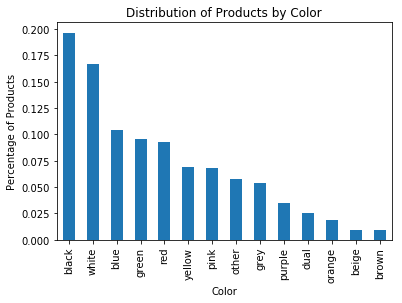

In [12]:
plt.title('Distribution of Products by Color')
plt.ylabel('Percentage of Products')
plt.xlabel('Color')
df1['new_color'].value_counts(normalize=True).plot(kind='bar')

#### Step 3d : Clean Categorical Variables - Product Categories
    
The Product Categories are not clearly defined in the dataset. 

I used the product description and matched it against reference list to assign a category to each and every product.
    
1. Create a list of categories (unique in nature) based on general business knowledge about clothing industry. This is our "Reference list"

2. Create a list of all possible unique product descriptions from 'title_orig' column. This is our "Input List".

3. Run a fuzzy string-to-string matching algorithm between the "Reference List" and "Input List" using fuzz module of fuzzywuzzy package to extract top categories of interest. 
    
4. Basically, this algorithm will match an element from "Input List" with each and every element in "Reference List" to generate a similarity score for each and every pair/combination.

5. Finally, I chose to preserve only those combinations that have a high similarity score (>=70). This indicates a strong match to the values (colors) in "Reference List".

Note: Remove all duplicate rows based on similarity scores. In case of ties, the first row was kept as best match. This may not be the best approach. However, it still tends to work in this case.


In [13]:
ref_list = ['Pants', 'Shorts', 'Shirt','TShirt','Top','Sleepwear','Dress','Beach','Bath','Fitness','Swim','Bikini','Jumpsuit','Yoga','Fitness','Jogging']

inp_list = df1['title_orig'].unique().tolist()


score_sort = [(x,) + i
             for x in inp_list 
             for i in process.extract(x, ref_list,scorer=fuzz.partial_ratio)]
#Create a dataframe from the tuples
similarity_sort = pd.DataFrame(score_sort, columns=['title_orig','prod_cat','score_sort'])


similarity_sort=similarity_sort[similarity_sort['score_sort']>=90]


df2=pd.merge(df1,similarity_sort,on='title_orig', how='left')

df2=df2.drop_duplicates('id')
print(df2.shape)


(1573, 45)


In [14]:
df2['prod_cat'].value_counts(normalize=True)

Dress        0.318704
Shirt        0.233626
Top          0.140446
Pants        0.121540
Shorts       0.074274
Beach        0.048616
Jumpsuit     0.024983
Swim         0.010804
Bath         0.009453
Jogging      0.006077
Sleepwear    0.004727
Yoga         0.003376
Bikini       0.002701
Fitness      0.000675
Name: prod_cat, dtype: float64

#### Step 3d : Clean Categorical Variables - Product Categories
    
The fuzzy match approach worked pretty good for the most part. However, there's still some opportunity to do additional cleaning and remove redundancy.

I tried to manually group all like categories into one major category to remove smaller or insignificant categories.

In [15]:
def f(df):
    if df['prod_cat'] in(['Swim','Bikini','Beach']) :
        val = 'Beach'
    elif df['prod_cat'] in(['Fitness','Jogging','Yoga']):
        val = 'Fitness'
    elif df['prod_cat'] in(['Pants']):
        val = 'Pants'
    elif df['prod_cat'] in(['Shorts']):
        val= 'Shorts'
    elif df['prod_cat'] in(['Shirt']):
        val= 'Shirt'
    elif df['prod_cat'] in(['TShirt']):
        val= 'TShirt'
    elif df['prod_cat'] in(['Top']):
        val= 'Top'
    elif df['prod_cat'] in(['Dress']):
        val= 'Dress'
    elif df['prod_cat'] in(['Bath']):
        val= 'Bath'
    elif df['prod_cat'] in(['Sleepwear']):
        val= 'Sleepwear'
    elif df['prod_cat'] in(['Jumpsuit']):
        val= 'Jumpsuit'
    else:
        val = 'Other'
    return val

df2['prod_cat'] = df2.apply(f, axis=1)


## Question 1: What are the top selling categories in Summer?

The top selling categories are Dress, Shirt, Top, Pants and Shorts.

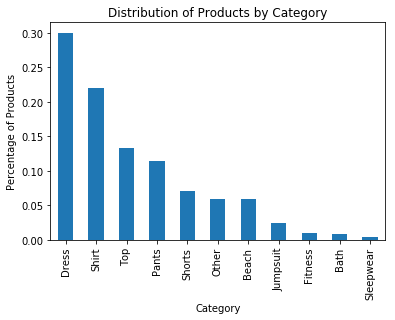

In [16]:
plt.title('Distribution of Products by Category')
plt.ylabel('Percentage of Products')
plt.xlabel('Category')
df2['prod_cat'].value_counts(normalize=True).plot(kind='bar')

#### Step 3d : Clean Categorical Variables - Product Size
    
This column was transformed in a similar fashion as the previous two columns. 

In [17]:
df2['product_variation_size_id'].value_counts()

S                              641
XS                             356
M                              200
XXS                            100
L                               49
S.                              18
XL                              17
XXL                             15
nan                             14
XXXS                             6
XS.                              5
s                                5
Size S                           5
4XL                              5
SIZE XS                          4
Size-XS                          4
2XL                              4
M.                               4
34                               3
10 ml                            3
2pcs                             3
33                               3
Size-S                           3
SizeL                            3
Size S.                          2
SIZE-XXS                         2
EU 35                            2
29                               2
1 pc.               

In [18]:

ref_list = ['XXXS','XXS','XS','S', 'M','L','XL','XXL','XXXL']

inp_list = df2['product_variation_size_id'].unique().tolist()


df2['product_variation_size_id'].replace('3XL', 'XXXL', inplace=True)
df2['product_variation_size_id'].replace('2XL', 'XXL', inplace=True)
df2['product_variation_size_id'].replace('04-3XL', 'XXXL', inplace=True)



score_sort = [(x,) + i
             for x in inp_list 
             for i in process.extract(x, ref_list,scorer=fuzz.token_set_ratio)]
#Create a dataframe from the tuples
similarity_sort = pd.DataFrame(score_sort, columns=['product_variation_size_id','size_id','score_sort'])


similarity_sort=similarity_sort[similarity_sort['score_sort']>90]

similarity_sort

df3=pd.merge(df2,similarity_sort,on='product_variation_size_id', how='left')

df3=df3.drop_duplicates('id')

#print(df3.shape)
#df1.tail()

In [19]:
df_3=df3[df3['size_id'].isnull()]
df_3['product_variation_size_id'].value_counts()

nan                             14
4XL                              5
SizeL                            3
2pcs                             3
10 ml                            3
34                               3
33                               3
EU 35                            2
29                               2
XXXXXL                           2
35                               2
XXXXL                            2
1                                2
25                               2
Size4XL                          2
One Size                         2
1 pc.                            2
5XL                              2
daughter 24M                     1
10pcs                            1
2                                1
100pcs                           1
100 cm                           1
17                               1
4                                1
H01                              1
30 cm                            1
White                            1
60                  

## Question 1: What are the top selling sizes in Summer?

The top selling sizes are - S, XS, M, and XXS.

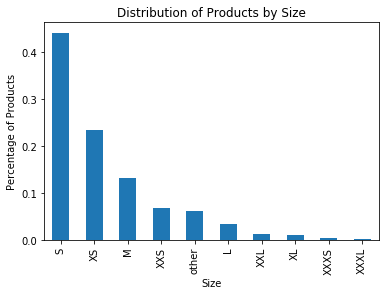

In [20]:
df3['size_id'].replace(np.nan, 'other', inplace=True)
plt.title('Distribution of Products by Size')
plt.ylabel('Percentage of Products')
plt.xlabel('Size')
df3['size_id'].value_counts(normalize=True).plot(kind='bar')

#### Step 3d : Transform Ordinal to Categorical Variables - Shipping Option Price
    
The Shipping Option Price variable has values which could render this variable to be ordinal in nature. Hence, it's important to transform it to a categorical variable.

In [21]:
df3['shipping_option_price'].value_counts()

conditions = [
    (df3['shipping_option_price'] == 1),
    (df3['shipping_option_price'] == 2),
    (df3['shipping_option_price'] == 3),
    (df3['shipping_option_price'] == 4),
    (df3['shipping_option_price'] == 5),
    (df3['shipping_option_price'] == 6),
    (df3['shipping_option_price'] == 7),
    (df3['shipping_option_price'] == 12)
    ]

# create a list of the values we want to assign for each condition
values = ['1', '2', '3', '4','5','6','7','12']

# create a new column and use np.select to assign values to it using our lists as arguments
df3['shipping_option'] = np.select(conditions, values)

# display updated DataFrame
df3.head()

,title_orig,price,retail_price,units_sold,uses_ad_boosts,rating,rating_count,rating_five_count,rating_four_count,rating_three_count,...,pct_badge_local_product,pct_badge_product_quality,pct_badge_fast_shipping,new_color,score_sort_x,prod_cat,score_sort_y,size_id,score_sort,shipping_option
0,2020 Summer Vintage Flamingo Print Pajamas Se...,16.00,14,100,0,3.76,54,26.0,8.0,10.0,...,0.0,0.0,0.0,white,100.0,Shorts,100.0,M,100.0,4
1,Women's Casual Summer Sleeveless Sexy Mini Dress,8.00,22,20000,1,3.45,6135,2269.0,1027.0,1118.0,...,0.0,0.0,0.0,green,100.0,Dress,100.0,XS,100.0,2
2,2020 New Arrival Women Spring and Summer Beach...,8.00,43,100,0,3.57,14,5.0,4.0,2.0,...,0.0,0.0,0.0,other,NaN,Beach,100.0,XS,100.0,3
3,Hot Summer Cool T Shirt for Women Fashion Tops...,8.00,8,5000,1,4.03,579,295.0,119.0,87.0,...,0.0,0.0,0.0,black,100.0,Shirt,100.0,M,100.0,2
4,Women Summer Shorts Lace Up Elastic Waistband ...,2.72,3,100,1,3.10,20,6.0,4.0,2.0,...,0.0,0.0,0.0,yellow,100.0,Pants,100.0,S,100.0,1


#### Step 3d : Clean Categorical Variable - Country of Origin
    
Based on data, it appears that this can be simplified into three major buckets - US, CN and Others.

In [22]:
def get_origin_country(df):
    if df['origin_country']=='US':
        val='US'
    elif df['origin_country']=='CN':
        val='CN'
    else:
        val='Others'
    return val
df3['origin_country']=df3.apply(get_origin_country,axis=1)
df3=df3.drop(['merchant_rating_count','rating_count','score_sort_x','score_sort','title_orig','id','product_variation_size_id','score_sort_y','product_color','product_id','inventory_total','product_variation_inventory'],axis=1)

In [23]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1573 entries, 0 to 1573
Data columns (total 36 columns):
price                           1573 non-null float64
retail_price                    1573 non-null int64
units_sold                      1573 non-null int64
uses_ad_boosts                  1573 non-null int64
rating                          1573 non-null float64
rating_five_count               1573 non-null float64
rating_four_count               1573 non-null float64
rating_three_count              1573 non-null float64
rating_two_count                1573 non-null float64
rating_one_count                1573 non-null float64
badges_count                    1573 non-null int64
badge_local_product             1573 non-null int64
badge_product_quality           1573 non-null int64
badge_fast_shipping             1573 non-null int64
shipping_option_price           1573 non-null int64
shipping_is_express             1573 non-null int64
countries_shipped_to            1573 non-null i

#### Step 3d : Transform Categorical Variable to Numeric Variable

Selected all previously processed categorical variables and created dummy variables for use in building models.

In [24]:
cat_df=df3.select_dtypes('object').columns

for col in cat_df:
    df3=pd.concat([df3.drop(col,axis=1),pd.get_dummies(df3[col],prefix=col, prefix_sep='_',dummy_na=False,drop_first=True)],axis=1)

df3.head()

,price,retail_price,units_sold,uses_ad_boosts,rating,rating_five_count,rating_four_count,rating_three_count,rating_two_count,rating_one_count,...,size_id_XXXL,size_id_XXXS,size_id_other,shipping_option_12,shipping_option_2,shipping_option_3,shipping_option_4,shipping_option_5,shipping_option_6,shipping_option_7
0,16.00,14,100,0,3.76,26.0,8.0,10.0,1.0,9.0,...,0,0,0,0,0,0,1,0,0,0
1,8.00,22,20000,1,3.45,2269.0,1027.0,1118.0,644.0,1077.0,...,0,0,0,0,1,0,0,0,0,0
2,8.00,43,100,0,3.57,5.0,4.0,2.0,0.0,3.0,...,0,0,0,0,0,1,0,0,0,0
3,8.00,8,5000,1,4.03,295.0,119.0,87.0,42.0,36.0,...,0,0,0,0,1,0,0,0,0,0
4,2.72,3,100,1,3.10,6.0,4.0,2.0,2.0,6.0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
df3=df3.fillna(0)
def missing_values_table(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        return mis_val_table_ren_columns
    
df_qa=missing_values_table(df3)
df_qa

Your selected dataframe has 72 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


#### Step 3d : Data Processing is complete. No missing values detected.

### Step 4 : Build a Model to Predict Number of Units Sold - Data Processing
    
1. Create two arrays X and Y each containing independent variables and the target variable (units sold) respectively.
2. Split data into training and validation datasets.
3. Standardize all features in training dataset using standard scaler (subtract by mean and divide by standard deviation) and apply the same standardization process to all variables in validation dataset.

In [26]:
# split the data randomly into training and validation datasets
X = df3.drop('units_sold',axis=1)
y = df3['units_sold']
    
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.3, random_state=42)

# standardize the data
stdsc = StandardScaler()
X_train_std = pd.DataFrame(stdsc.fit_transform(X_train))
X_train_std.columns = X_train.columns

X_valid_std = pd.DataFrame(stdsc.transform(X_valid))
X_valid_std.columns = X_valid.columns

X_train_std.head()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by StandardScaler.
  if sys.path[0] == '':


,price,retail_price,uses_ad_boosts,rating,rating_five_count,rating_four_count,rating_three_count,rating_two_count,rating_one_count,badges_count,...,size_id_XXXL,size_id_XXXS,size_id_other,shipping_option_12,shipping_option_2,shipping_option_3,shipping_option_4,shipping_option_5,shipping_option_6,shipping_option_7
0,-0.653976,-0.535314,-0.867862,0.791692,-0.272584,-0.285729,-0.327263,-0.309837,-0.407802,-0.31268,...,-0.04266,-0.067543,-0.26648,-0.030151,1.242065,-0.708552,-0.213504,-0.146068,-0.085553,-0.060385
1,1.190196,0.209876,-0.867862,-1.699559,0.396413,0.697665,1.590694,3.083295,4.160780,-0.31268,...,-0.04266,-0.067543,-0.26648,-0.030151,-0.805111,1.411328,-0.213504,-0.146068,-0.085553,-0.060385
2,-0.064343,-0.340917,-0.867862,0.316262,0.952270,0.827965,0.815629,0.740583,0.730726,-0.31268,...,-0.04266,-0.067543,-0.26648,-0.030151,-0.805111,1.411328,-0.213504,-0.146068,-0.085553,-0.060385
3,-0.899866,-0.632513,1.152257,-1.794645,-0.434914,-0.428322,-0.379810,-0.392765,-0.340262,-0.31268,...,-0.04266,-0.067543,-0.26648,-0.030151,-0.805111,-0.708552,-0.213504,-0.146068,-0.085553,-0.060385
4,-0.064343,-0.535314,1.152257,-0.938872,-0.451639,-0.452906,-0.448777,-0.441140,-0.456045,-0.31268,...,-0.04266,-0.067543,-0.26648,-0.030151,1.242065,-0.708552,-0.213504,-0.146068,-0.085553,-0.060385


### Step 4 : Build a Model to Predict Number of Units Sold - Feature Importance

4. Use feature importance attribute to identify top 15 variables to predict units sold. This would help eliminate multicollinearity and thereby control for overfitting to some extent. 

In [27]:
### Feature importance with Random Forest ###

feat_labels = pd.DataFrame(X_train_std.columns[1:])
forest = RandomForestRegressor(n_estimators = 500,
                               random_state = 0,
                               n_jobs = -1)
forest.fit(X_train, y_train)
importances = pd.DataFrame(forest.feature_importances_)

rf_importances = feat_labels.merge(importances,left_index = True, right_index = True)
rf_importances.columns = ['features','rf_importance']
rf_importances.sort_values('rf_importance', ascending = False, inplace = True) 
rf_importances['rf_rank'] = range(1, len(rf_importances) + 1)

top_vars = rf_importances.iloc[:15,0].tolist()
X_train_top = X_train_std[top_vars]
X_valid_top = X_valid_std[top_vars]

rf_importances=rf_importances[rf_importances['rf_rank'] <=15]
rf_importances

,features,rf_importance,rf_rank
6,rating_two_count,0.360504,1
4,rating_four_count,0.212745,2
5,rating_three_count,0.201866,3
7,rating_one_count,0.107126,4
15,has_urgency_banner,0.012988,5
0,retail_price,0.009033,6
1,uses_ad_boosts,0.007967,7
25,pct_rating_five,0.007024,8
8,badges_count,0.006232,9
26,pct_badge_local_product,0.006221,10


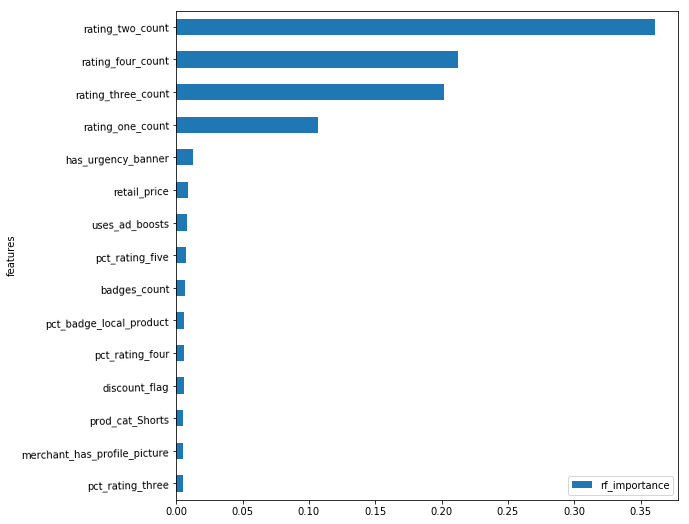

In [28]:
plt.rcParams["figure.figsize"] = (9,9)
rf_importances.sort_values('rf_importance',inplace=True)
ax = rf_importances.plot.barh(x='features', y='rf_importance', rot=1)

### Step 4 : Build a Model to Predict Number of Units Sold - Test Different Algorithms
5. Test different machine learning algorithms to see which algorithm predicts the target variable the best (minimum MSE or high R Square). The best algorithm will have a high R2 score on both train and validation dataset. This indicates that the given model is balanced and is able to maintain a steady bias/variance trade-off.  

In [29]:
# Importing models
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor

# Regression Metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Cross validation
from sklearn.model_selection import cross_val_score


regressors = [LinearRegression(),
             DecisionTreeRegressor(random_state=1),
             RandomForestRegressor(n_estimators = 10, random_state=1),
             GradientBoostingRegressor(random_state = 0),
             linear_model.Lasso(alpha=10)]

df = pd.DataFrame(columns = ['Name', 'Train Score', 'Test Score', 'Mean Absolute Error', 'Mean Squared Error', 
                             'Cross Validation Score (Mean Accuracy)', 'R2 Score'])

for regressor in regressors:
    regressor.fit(X_train_top, y_train)
    y_pred = regressor.predict(X_valid_top)
    
    # print classifier name
    s = str(type(regressor)).split('.')[-1][:-2]
    
    # Train Score
    train = regressor.score(X_train_top, y_train)
    
    # Test Score
    test = regressor.score(X_valid_top, y_valid)
    
    # MAE score
    mae = mean_absolute_error(y_valid, y_pred)
    
    # MSE Score
    mse = mean_squared_error(y_valid, y_pred)
    
    accuracy = cross_val_score(estimator = regressor, X = X_train_top, y = y_train, cv=10)
    cv = accuracy.mean()*100
    
    r2 = r2_score(y_valid, y_pred)
    
    df = df.append({'Name': s, 'Train Score': train, 'Test Score': test, 'Mean Absolute Error': mae, 
                    'Mean Squared Error': mse, 'Cross Validation Score (Mean Accuracy)': cv,
                   'R2 Score': r2},
                  ignore_index=True)
df.head()

,Name,Train Score,Test Score,Mean Absolute Error,Mean Squared Error,Cross Validation Score (Mean Accuracy),R2 Score
0,LinearRegression,0.811752,0.802798,2022.479878,2.025618e+07,78.246778,0.802798
1,DecisionTreeRegressor,1.000000,0.718718,1562.906780,2.889262e+07,63.205995,0.718718
2,RandomForestRegressor,0.959076,0.801226,1486.493644,2.041758e+07,78.114322,0.801226
3,GradientBoostingRegressor,0.969648,0.795102,1603.388000,2.104662e+07,74.649770,0.795102
4,Lasso,0.811665,0.802909,2009.502295,2.024474e+07,78.589507,0.802909


Based on the output above, it's clear that Lasso Model has a higer R Square on both Train and Validation dataset. In addition, it also has a lower mean square error too. It's the best model in comparison to other models. The reason being that the other models are overfitting the data while the LASSO/Linear Regression is clearly not.  